import libraries

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

read data into pd

In [18]:
data = pd.read_csv('email_with_predicted_roles_V2.csv')
# data = data.drop(columns=['Content','Total_Sentence_Word_Count','From_Names','To_Names','Cleaned_Content','BoW','DateTime'])


preprocess the data to remove weird and non-enron emails
- initially there are about 19k unique entries under From column

In [ ]:
data['From'] = data['From'].str.strip().replace('', pd.NA)
data = data.dropna(subset=['From'])

# Filter rows where 'From' ends with '@enron.com' and does not contain numbers before '@enron.com'
filtered_data = data[
    data['From'].str.contains('@enron\.com$', na=False, regex=True) &  # Ends with '@enron.com'
    ~data['From'].str.contains(r'\d+@enron\.com$', na=False, regex=True)  # Does not contain numbers before '@enron.com'
]

<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Yap Yee Peng\AppData\Local\Temp\ipykernel_12908\710275862.py:6: SyntaxWarning: invalid escape sequence '\.'
  data['From'].str.contains('@enron\.com$', na=False, regex=True) &  # Ends with '@enron.com'


In [20]:
# Split the 'To' column into a list of recipients
filtered_data['To'] = filtered_data['To'].str.split(',')

filtered_data = filtered_data.explode('To')

filtered_data = filtered_data.dropna(subset=['From', 'To'])

filtered_data['From'] = filtered_data['From'].str.strip()
filtered_data['To'] = filtered_data['To'].str.strip()

filtered_data = filtered_data[filtered_data['From'].str.contains('@', na=False)]
filtered_data = filtered_data[filtered_data['To'].str.contains('@', na=False)]

filtered_data['To'] = filtered_data['To'].str.strip().replace('', pd.NA)
filtered_data = filtered_data.dropna(subset=['To'])

filtered_data_2 = filtered_data[
    filtered_data['To'].str.contains('@enron\.com$', na=False, regex=True) &
    ~filtered_data['To'].str.contains(r'\d+@enron\.com$', na=False, regex=True)
]

<>:18: SyntaxWarning: invalid escape sequence '\.'
<>:18: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Yap Yee Peng\AppData\Local\Temp\ipykernel_12908\658387725.py:18: SyntaxWarning: invalid escape sequence '\.'
  filtered_data['To'].str.contains('@enron\.com$', na=False, regex=True) &


prepare node edges + create foundation for graph
- using From and To columns only, that will match with Job_Title later on

In [7]:
edges = filtered_data_2[['From', 'To']]

In [8]:
# Create a directed graph
G = nx.DiGraph()

# Add edges from the DataFrame
for _, row in edges.iterrows():
    G.add_edge(row['From'], row['To'])

1. Calculate degree centrality
- node's importance by counting the number of direct connetions (edges) it has to other nodes

In [9]:
degree_centrality = nx.degree_centrality(G)

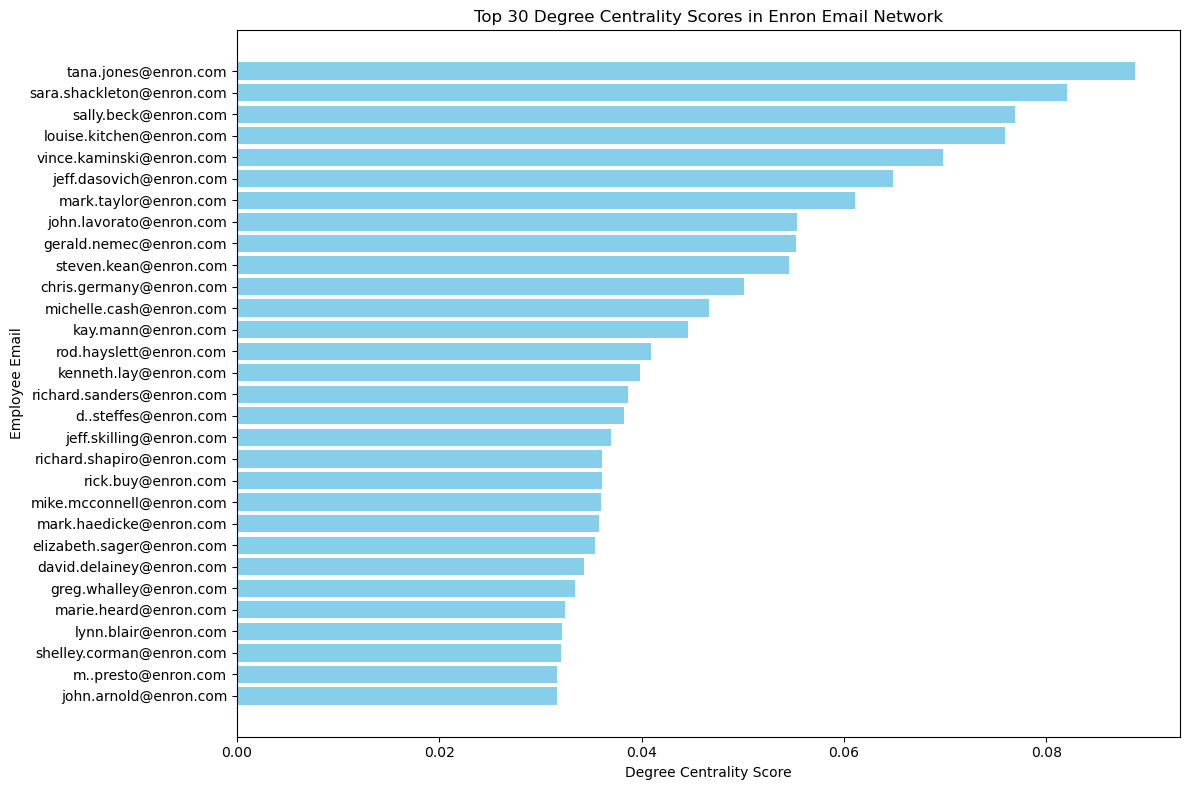

In [10]:
# Sort nodes by degree centrality scores in descending order
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Get the top 30 nodes with the highest degree centrality
top_30 = sorted_degree_centrality[:30]

# Extract names and scores for the bar graph
names = [x[0] for x in top_30]
scores = [x[1] for x in top_30]

plt.figure(figsize=(12, 8))
plt.barh(names, scores, color='skyblue')
plt.xlabel('Degree Centrality Score')
plt.ylabel('Employee Email')
plt.title('Top 30 Degree Centrality Scores in Enron Email Network')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()

In [11]:
# Extract email addresses of the top 30
top_30_emails = [x[0] for x in top_30]

# Create a dictionary to store email-job_title pairs
email_to_job_title = {}

# Look through the entire 'From' list and match with the top 20 emails
for email in top_30_emails:
    job_title = data.loc[data['From'] == email, 'Job_Title'].drop_duplicates().values
    if len(job_title) > 0:
        email_to_job_title[email] = job_title[0]
    else:
        email_to_job_title[email] = 'Unknown'

top_30_with_titles = pd.DataFrame(top_30, columns=['email', 'degree_centrality'])
top_30_with_titles['Job_Title'] = top_30_with_titles['email'].map(email_to_job_title)

top_30_with_titles.head(30)

,email,degree_centrality,Job_Title
0,tana.jones@enron.com,0.088765,"Vice President, Chief Financial Officer and Tr..."
1,sara.shackleton@enron.com,0.081998,"Vice President, Enron Wholesale Services"
2,sally.beck@enron.com,0.076923,Chief Operating Officer
3,louise.kitchen@enron.com,0.075928,"President, Enron Online"
4,vince.kaminski@enron.com,0.069758,"Manager, Risk Management Head"
5,jeff.dasovich@enron.com,0.064882,Government Relation Executive
6,mark.taylor@enron.com,0.061101,"Managing Director, Legal Department"
7,john.lavorato@enron.com,0.055329,"CEO, Enron America"
8,gerald.nemec@enron.com,0.055229,"Manager, Logistics Manager"
9,steven.kean@enron.com,0.054533,"Vice President, Vice President & Chief of Staff"


chart of top 30 degree centrality

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

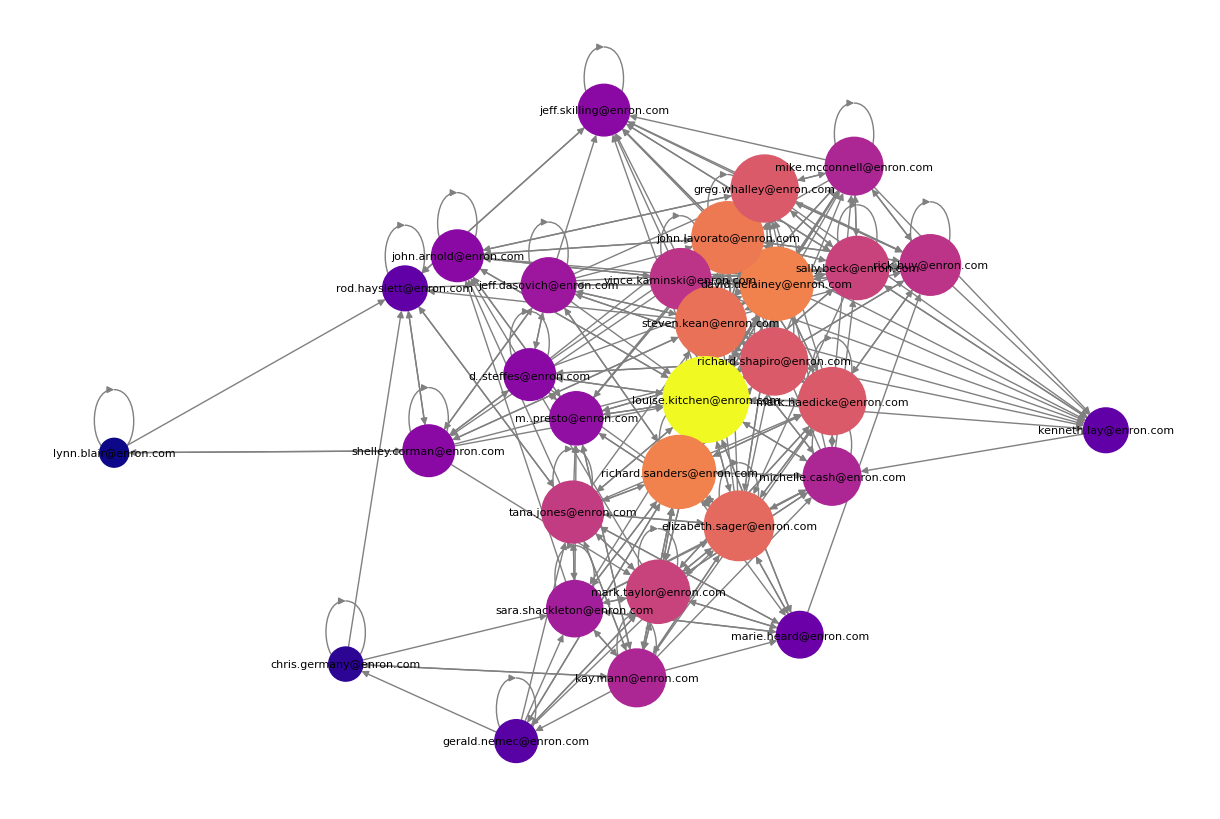

In [29]:
# Get the top 30 employees based on degree centrality
top_30 = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:30]

# Create a subgraph with the top 30 employees
subgraph = G.subgraph(top_30)

# Calculate degree centrality for the subgraph
subgraph_degree_centrality = nx.degree_centrality(subgraph)

# Set node size and color based on degree centrality
node_size = [v * 2500 for v in subgraph_degree_centrality.values()]  # Scale for visibility
node_color = [v * 50 for v in subgraph_degree_centrality.values()]  # Scale for color intensity

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.plasma, with_labels=True, font_size=8, font_color='black', edge_color='gray')

sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=min(node_color), vmax=max(node_color)))
sm.set_array([])
plt.colorbar(sm, label='Degree Centrality')

plt.title('Top 30 Employees by Degree Centrality')

NER - top frequent persons
- jeff - found 2
- chris - found
- vince - found
- john - found 2
- mike - found

In [19]:
print("jeff.dasovich@enron.com: " + data[data["From"] == "jeff.dasovich@enron.com"]["Job_Title"].unique()) #'Government Relation Executive'
print("jeff.skilling@enron.com: " + data[data["From"] == "jeff.skilling@enron.com"]["Job_Title"].unique()) #'Government Relation Executive'
print("chris.germany@enron.com: " + data[data["From"] == "chris.germany@enron.com"]["Job_Title"].unique()) #'Vice President'
print("vince.kaminski@enron.com: " + data[data["From"] == "vince.kaminski@enron.com"]["Job_Title"].unique()) #'Vice President'
print("john.lavorato@enron.com: " + data[data["From"] == "john.lavorato@enron.com"]["Job_Title"].unique()) #'CEO, Enron America'
print("john.arnold@enron.com: " + data[data["From"] == "john.arnold@enron.com"]["Job_Title"].unique()) #'Vice President'
print("mike.mcconnell@enron.com: " + data[data["From"] == "mike.mcconnell@enron.com"]["Job_Title"].unique()) #'Vice President'


['jeff.dasovich@enron.com: Government Relation Executive']
['jeff.skilling@enron.com: Government Relation Executive']
['chris.germany@enron.com: Vice President']
['vince.kaminski@enron.com: Manager, Risk Management Head']
['john.lavorato@enron.com: CEO, Enron America']
['john.arnold@enron.com: Vice President']
['mike.mcconnell@enron.com: Vice President']


mapping with labels for top few degree centrality (from)
- labels of email content they sent

In [9]:
def get_labels_by_email(df, email):
    # Filter rows for the given email
    email_data = df[df['From'] == email]
    
    # Count occurrences of each label
    label_counts = email_data['Label'].value_counts().reset_index()
    label_counts.columns = ['Label', 'count']
    
    # Sort by count in descending order
    label_counts = label_counts.sort_values('count', ascending=False)
    
    return label_counts


In [13]:
email = 'tana.jones@enron.com'
result = get_labels_by_email(data, email)
print('Employee email: tana.jones@enron.com')
print(result)

Employee email: tana.jones@enron.com
                                               Label  count
0                   Energy Trading & Legal Contracts   6421
1                      Casual/Internal Email Chatter   1000
2             Corporate Strategy, Risk, & Operations    537
3           Energy Market & State-Level Power Issues    105
4                Internal Communications & Personnel     94
5  Regulatory & Infrastructure (FERC, ISO, Transm...     10


In [ ]:
email = 'sara.shackleton@enron.com'
result = get_labels_by_email(data, email)
print('Employee email: sara.shackleton@enron.com')
print(result)

Employee email: sara.shackleton@enron.com
                                               Label  count
0                   Energy Trading & Legal Contracts   7010
1                      Casual/Internal Email Chatter    902
2             Corporate Strategy, Risk, & Operations    540
3                Internal Communications & Personnel    129
4           Energy Market & State-Level Power Issues     56
5  Regulatory & Infrastructure (FERC, ISO, Transm...     15


In [25]:
email = 'sally.beck@enron.com'
result = get_labels_by_email(data, email)
print('Employee email: sally.beck@enron.com')
print(result)

Employee email: sally.beck@enron.com
                                      Label  count
0    Corporate Strategy, Risk, & Operations   2091
1             Casual/Internal Email Chatter   1452
2       Internal Communications & Personnel    686
3          Energy Trading & Legal Contracts     84
4  Energy Market & State-Level Power Issues      2


mapping with labels for top-3 degree centrality (to)
- labels of email content they received

In [ ]:
def get_labels_by_email_to(df, email):
    # Filter rows for the given email
    email_data = df[df['To'] == email]
    
    # Count occurrences of each label
    label_counts = email_data['Label'].value_counts().reset_index()
    label_counts.columns = ['Label', 'count']
    
    # Sort by count in descending order
    label_counts = label_counts.sort_values('count', ascending=False)
    
    return label_counts

In [20]:
email_to_1 = 'tana.jones@enron.com'
result_to_1 = get_labels_by_email_to(filtered_data_2, email_to_1)
print('Employee email: tana.jones@enron.com')
print(result_to_1)

Employee email: tana.jones@enron.com
                                               Label  count
0                   Energy Trading & Legal Contracts   4989
1                      Casual/Internal Email Chatter    550
2             Corporate Strategy, Risk, & Operations    402
3                Internal Communications & Personnel     73
4           Energy Market & State-Level Power Issues     28
5  Regulatory & Infrastructure (FERC, ISO, Transm...     14


In [21]:
email_to_2 = 'sara.shackleton@enron.com'
result_to_2 = get_labels_by_email_to(filtered_data_2, email_to_2)
print('Employee email: sara.shackleton@enron.com')
print(result_to_2)

Employee email: sara.shackleton@enron.com
                                               Label  count
0                   Energy Trading & Legal Contracts   4281
1                      Casual/Internal Email Chatter    560
2             Corporate Strategy, Risk, & Operations    399
3           Energy Market & State-Level Power Issues     78
4                Internal Communications & Personnel     75
5  Regulatory & Infrastructure (FERC, ISO, Transm...     13


In [24]:
email_to_3 = 'sally.beck@enron.com'
result_to_3 = get_labels_by_email_to(filtered_data_2, email_to_3)
print('Employee email: sally.beck@enron.com')
print(result_to_3)

Employee email: sally.beck@enron.com
                                               Label  count
0             Corporate Strategy, Risk, & Operations   2568
1                      Casual/Internal Email Chatter    672
2                Internal Communications & Personnel    412
3                   Energy Trading & Legal Contracts    264
4           Energy Market & State-Level Power Issues     25
5  Regulatory & Infrastructure (FERC, ISO, Transm...      4
